### Importing the required packages

In [1]:
import pandas as pd
import numpy as np
import random 

#sklearn
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

#tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


#keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras import layers, models
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils.vis_utils import plot_model




### Unzipping the audio images 


In [2]:
!unzip "/content/spectogram_images.zip" -d "/content/spectogram_images/"

Archive:  /content/spectogram_images.zip
   creating: /content/spectogram_images/spectogram_images/
  inflating: /content/spectogram_images/spectogram_images/713_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/390_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/444_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/669_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/340_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/627_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/368_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/641_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/326_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/691_P_spectrogram.png  
  inflating: /content/spectogram_images/spectogram_images/422_P_spectrogram.png 

In [3]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 4.0 MB 24.7 MB/s 
     |████████████████████████████████| 1.2 MB 55.8 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 880 kB 74.9 MB/s 
     |████████████████████████████████| 6.6 MB 66.4 MB/s 
     |████████████████████████████████| 596 kB 90.9 MB/s 
     |████████████████████████████████| 96 kB 7.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=97a44da7aab2d522e0d9a9bf1e1d9a9c9c565f6ed3c1512d7b4aabf3883bd4a4
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.50-py3-none-any.whl size=895166 sha256=978223a396294048e507d0e7a3c3ef84998a47f931f1ae1bf47e7f294c5366aa
  Stored in directory: /root/.cache/pip/wheels/d9/72/54/519f0d5143cc6c73fa3297509123c86fc8586a

### Loading the pretrained bert model for encoding the text representations of audio transcripts


In [4]:
# referred from https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models/

from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

bertmodel = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')
embeddings = bertmodel.encode(sentences)


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [5]:
embeddings.shape

(2, 768)

### Loading the train test split samples from csv

In [6]:
train_text_split = pd.read_csv("/content/train_text_split.csv")
test_text_split = pd.read_csv("/content/test_text_split.csv")

print(train_text_split.head())
# loading the train, test binary PHQ8-lables 
train_lable = train_text_split["PHQ_Binary"].values
test_lables = test_text_split["PHQ_Binary"].values

#train_lables for PHQ8 score 
train_phq_lables = train_text_split["PHQ_Score"].values
test_phq_lables = test_text_split["PHQ_Score"].values


   Participant_ID   Gender  PHQ_Binary  PHQ_Score  PCL-C (PTSD)  \
0             302     male           0          4             0   
1             303   female           0          0             0   
2             304   female           0          6             0   
3             305     male           0          7             0   
4             307  female            0          4             0   

   PTSD Severity  Sample                                         Transcript  
0             28     302  just move around a little bit  when you're fin...  
1             17     303  wow okay  when you're finished when she's done...  
2             20     304  so we'll just move around a little bit tonight...  
3             28     305  okay looks good so we can just move around a l...  
4             23     307  looking at you all right okay so now let's mak...  


In [7]:
# counting the distribution of classes in test data
d = {}
for item in test_lables:
    if item in d:
        d[item] = d.get(item)+1
    else:
        d[item] = 1

for k,v in d.items():
    print(str(k)+':'+str(v))


0:39
1:17


In [8]:
# counting the distribution of classes in train data

d = {}
for item in train_lable:
    if item in d:
        d[item] = d.get(item)+1
    else:
        d[item] = 1

for k,v in d.items():
    print(str(k)+':'+str(v))


0:126
1:37


## converting images to numpy array and text to vector representation

In [9]:
image_path = "/content/spectogram_images/spectogram_images/{}_P_spectrogram.png"
img = load_img(image_path.format(str(train_text_split["Participant_ID"].iloc[0])))

img_array = img_to_array(img)
print(img_array.shape)

(288, 432, 3)


In [10]:
train_lable.shape

(163,)

In [11]:
train_image_array = np.empty((1,288,432,3))
train_bert = np.empty((1,768))
test_bert = np.empty((1,768))
test_image_array = np.empty((1,288,432,3))

image_path = "/content/spectogram_images/spectogram_images/{}_P_spectrogram.png"

for i in range(len(train_text_split)):
  img = load_img(image_path.format(str(train_text_split["Participant_ID"].iloc[i])))
  text_emb =  bertmodel.encode([train_text_split["Transcript"].iloc[i]])
  img_array = img_to_array(img).reshape(1,288,432,3)
  train_image_array = np.vstack((train_image_array,img_array))
  train_bert = np.vstack((train_bert,text_emb))

train_image_array = np.delete(train_image_array,0,axis=0)
train_bert = np.delete(train_bert,0,axis=0)

for i in range(len(test_text_split)):
  img = load_img(image_path.format(str(test_text_split["Participant_ID"].iloc[i])))
  img_array = img_to_array(img).reshape(1,288,432,3)
  text_emb =  bertmodel.encode([test_text_split["Transcript"].iloc[i]])
  test_image_array = np.vstack((test_image_array,img_array))
  test_bert = np.vstack((test_bert,text_emb))

test_image_array = np.delete(test_image_array,0,axis=0)
test_bert = np.delete(test_bert,0,axis=0)


np.save("train_image_3_channels.npy", train_image_array)
np.save("train_text.npy", train_bert)
np.save("test_image_3_channels.npy", test_image_array)
np.save("test_text.npy", test_bert)

In [12]:
del train_image_array, train_bert,test_image_array,test_bert

### Data Augmentation with upsampling for depression class


In [13]:
train_image_array = np.load("train_image_3_channels.npy")
train_bert = np.load("train_text.npy")
test_image_array = np.load("test_image_3_channels.npy")
test_bert = np.load("test_text.npy")

train_image_array_final = np.empty((1,288,432,3))
train_bert_final = np.empty((1,768))
num_classes = max(train_lable) + 1
digit_indices = [np.where(train_lable == i)[0] for i in range(num_classes)]
print(digit_indices)
train_lables = train_lable.tolist()
train_phq_lables = train_phq_lables.tolist()
for i in range(89):
  idx2 = random.choice(digit_indices[1])
  img_array = train_image_array[idx2].reshape(1,288,432,3)
  bert = train_bert[idx2].reshape(1,768)
  train_image_array_final = np.vstack((train_image_array_final,img_array))
  train_lables.append(1)
  train_phq_lables.append(train_phq_lables[idx2])
  train_bert_final  = np.vstack((train_bert_final,bert))
print(train_lables)
train_image_array_final = np.delete(train_image_array_final,0,axis=0)
train_bert_final = np.delete(train_bert_final,0,axis=0)

train_image_array = np.vstack((train_image_array,train_image_array_final))
train_bert = np.vstack((train_bert,train_bert_final))

[array([  0,   1,   2,   3,   4,   7,   9,  10,  11,  12,  13,  14,  16,
        17,  18,  19,  20,  21,  22,  23,  26,  27,  31,  32,  36,  38,
        42,  43,  44,  46,  47,  49,  50,  51,  53,  54,  55,  57,  60,
        61,  62,  63,  65,  66,  67,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  80,  81,  82,  84,  85,  87,  88,  89,  90,  91,
        93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107,
       108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       150, 151, 152, 157, 158, 159, 160, 161, 162]), array([  5,   6,   8,  15,  24,  25,  28,  29,  30,  33,  34,  35,  37,
        39,  40,  41,  45,  48,  52,  56,  58,  59,  64,  68,  79,  83,
        86,  92,  95, 105, 114, 119, 149, 153, 154, 155, 156])]
[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1

In [ ]:
# referred from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()
scaler.fit(np.array(train_phq_lables).reshape(-1,1))
train_phq_lables =  scaler.transform(np.array(train_phq_lables).reshape(-1,1))
test_phq_lables = scaler.transform(np.array(test_phq_lables).reshape(-1,1))

In [ ]:
# converting the image scale from 0-255 to 0-1
train_image_array = train_image_array/255
test_image_array = test_image_array/255

In [15]:
print(train_lables)
print(type(train_lables))
train_lables = list(train_lables)
print(train_lables)

digit_indices = [np.where(train_lables == i)[0] for i in range(num_classes)]
print(digit_indices)

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<class 'list'>
[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [16]:
len(train_lables)

252

In [17]:
train_images, train_text, train_lables,train_phq_lables = shuffle(train_image_array,train_bert,train_lables,train_phq_lables,random_state=42)

In [ ]:
train_phq_lables

### Experimenting depression classification using pretrained VGG16 model


Referred from: 
https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

In [ ]:
#downloading the pretrained vgg16 model
vggmodel  = VGG16(weights="imagenet", include_top=False,input_shape=(288,432,3))
vggmodel.trainable = False ## Not trainable weights

vggmodel.summary()

#getting the out of images in pre-trained vgg16 network
train_ds = preprocess_input(train_images) 
test_ds = preprocess_input(test_image_array)

'''#Converting labels to categorical variables
train_labels = to_categorical(train_lables, num_classes=2)
test_labels = to_categorical(test_lables, num_classes=2)'''

#defining the custom dense layers 
flatten_layer = layers.Flatten()

dense_layer_1 = layers.Dense(4096, activation='relu')
dp1 = layers.Dropout(0.4)
dense_layer_2 = layers.Dense(1024, activation='relu')
dp2 = layers.Dropout(0.4)
dense_layer_3 = layers.Dense(512, activation='relu')
dense_layer_4 = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(1)


custom_vgg_model = models.Sequential([
    vggmodel,
    flatten_layer,
    dense_layer_1,
    dp1,
    dense_layer_2,
    dp2,
    dense_layer_3,
    dense_layer_4,
    prediction_layer
])



58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 288, 432, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 288, 432, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 144, 216, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 144, 216, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 144, 216, 128)     147584    
                                                              

In [ ]:
custom_vgg_model.compile(
    optimizer='RMSprop',
    loss='mse',
    metrics=['mse','mae'],
)



es = EarlyStopping(monitor='mse', mode='max', patience=5,  restore_best_weights=True)

custom_vgg_model.fit(train_ds, np.array(train_phq_lables), epochs=100, validation_split=0.2, batch_size=16,callbacks=[es])

Epoch 1/100
13/13 [==============================] - 22s 720ms/step - loss: 57144.2578 - mse: 57144.2578 - mae: 68.2165 - val_loss: 0.2317 - val_mse: 0.2317 - val_mae: 0.3775
Epoch 2/100
13/13 [==============================] - 4s 313ms/step - loss: 0.2892 - mse: 0.2892 - mae: 0.4317 - val_loss: 0.1780 - val_mse: 0.1780 - val_mae: 0.3406
Epoch 3/100
13/13 [==============================] - 4s 313ms/step - loss: 0.2121 - mse: 0.2121 - mae: 0.3763 - val_loss: 0.2289 - val_mse: 0.2289 - val_mae: 0.3752
Epoch 4/100
13/13 [==============================] - 4s 317ms/step - loss: 0.2167 - mse: 0.2167 - mae: 0.3559 - val_loss: 0.1305 - val_mse: 0.1305 - val_mae: 0.3165
Epoch 5/100
13/13 [==============================] - 4s 315ms/step - loss: 0.1643 - mse: 0.1643 - mae: 0.3194 - val_loss: 0.1263 - val_mse: 0.1263 - val_mae: 0.3148
Epoch 6/100
13/13 [==============================] - 4s 337ms/step - loss: 0.1416 - mse: 0.1416 - mae: 0.3034 - val_loss: 0.1742 - val_mse: 0.1742 - val_mae: 0.3384


In [ ]:
yhat = custom_vgg_model.predict(test_ds)


In [ ]:
yhat

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(yhat, test_phq_lables)
mse = mean_squared_error(yhat,test_phq_lables,squared=True)
print(mse,mae)

0.1451734550732117 0.2932357133499214


In [ ]:
print("Mean absolute error on test data: ", mae*23)
print("Root Meansquare error on test data: ", mse*23*23)

Mean absolute error on test data:  6.744421407048192
Root Meansquare error on test data:  76.796757733729


### Experimenting custom vgg16 net

Referred from : https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 288, 432, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 288, 432, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 144, 216, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 216, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 144, 216, 128)     147584    
                                                             

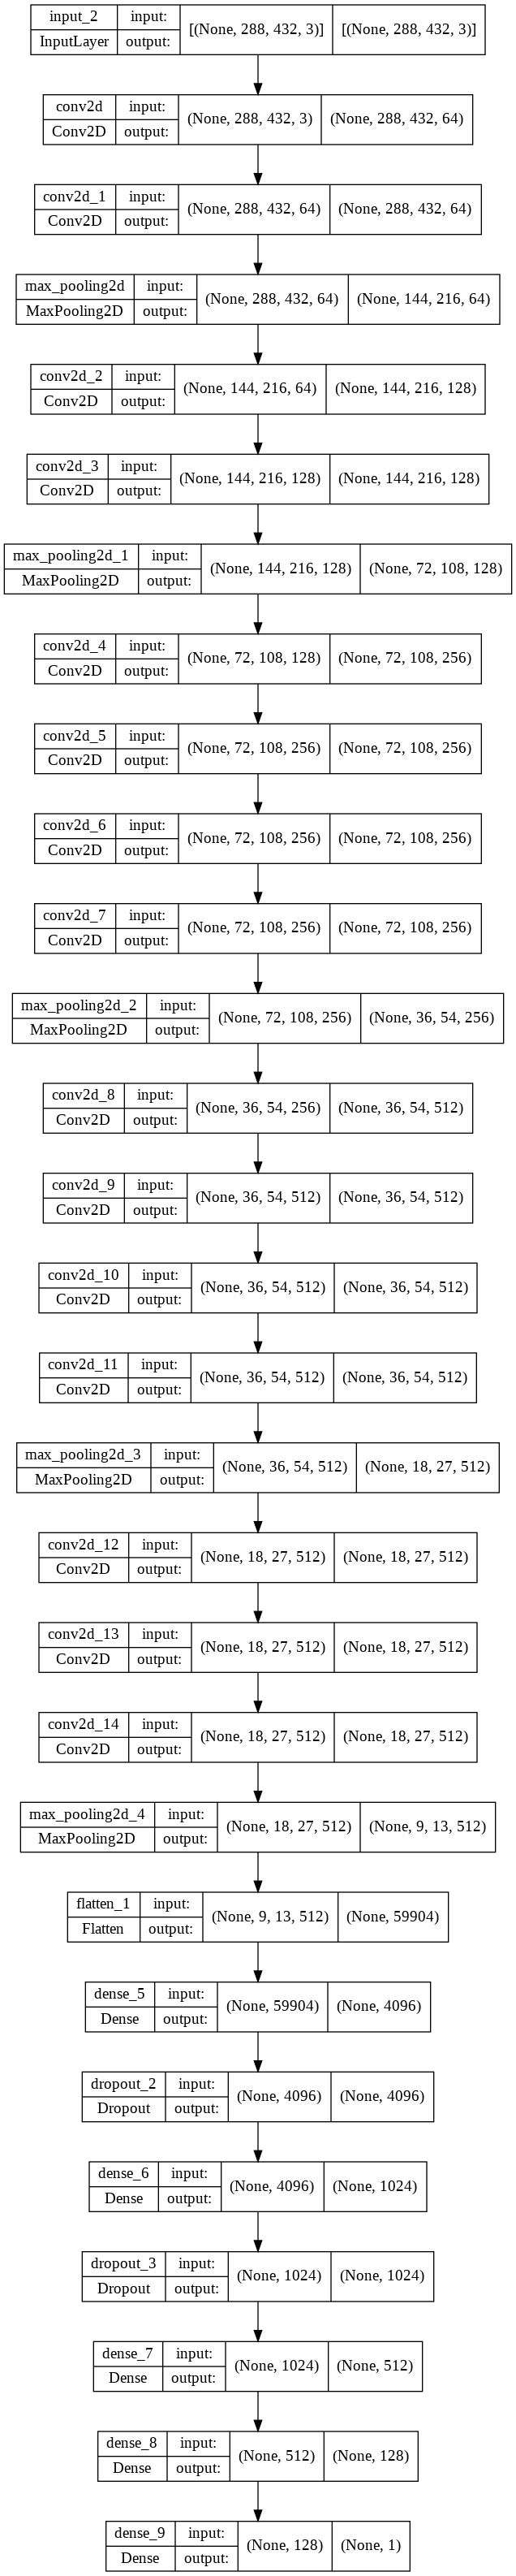

In [ ]:
#scrath implementation of VGG model


# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

#train_lables = to_categorical(train_lables, num_classes=2)
#test_lables = to_categorical(test_lables, num_classes=2)


# define model input
visible = Input(shape=(288, 432, 3))
# add vgg module
layer = vgg_block(visible, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 4)
# add vgg module

layer = vgg_block(layer, 512, 4)

# add vgg module

layer = vgg_block(layer, 512, 3)

flatten_layer = layers.Flatten()(layer)
dense_layer_1 = layers.Dense(4096, activation='relu')(flatten_layer)
dp1 = layers.Dropout(0.5)(dense_layer_1)
dense_layer_2 = layers.Dense(1024, activation='relu')(dp1)
dp2 = layers.Dropout(0.4)(dense_layer_2)
dense_layer_3 = layers.Dense(512, activation='relu')(dp2)
dense_layer_4 = layers.Dense(128, activation='relu')(dense_layer_3)
prediction_layer = layers.Dense(1)(dense_layer_4)

# create model
model = Model(inputs=visible, outputs=prediction_layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='custom_vgg_blocks.png')

In [ ]:
len(train_lables)

252

In [ ]:
optim = tf.keras.optimizers.Adam(
    # learning_rate=0.001,
    learning_rate=0.001,
    # learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)
model.compile(loss='mse', metrics=['mse', 'mae'], optimizer=optim)
#model.compile(optimizer='RMSprop',loss='mse',metrics=['mse','mae'],)
es = EarlyStopping(monitor='mse', mode='max', patience=5,  restore_best_weights=True)

model.fit(train_images,np.array(train_phq_lables), epochs=30, validation_split=0.2, batch_size=1)


Epoch 1/30
201/201 [==============================] - 28s 124ms/step - loss: 13220.8135 - mse: 13220.8135 - mae: 8.6258 - val_loss: 0.1124 - val_mse: 0.1124 - val_mae: 0.3088
Epoch 2/30
201/201 [==============================] - 25s 124ms/step - loss: 0.0981 - mse: 0.0981 - mae: 0.2716 - val_loss: 0.1104 - val_mse: 0.1104 - val_mae: 0.3084
Epoch 3/30
201/201 [==============================] - 24s 122ms/step - loss: 0.0922 - mse: 0.0922 - mae: 0.2582 - val_loss: 0.1141 - val_mse: 0.1141 - val_mae: 0.3112
Epoch 4/30
201/201 [==============================] - 24s 121ms/step - loss: 0.0892 - mse: 0.0892 - mae: 0.2522 - val_loss: 0.1179 - val_mse: 0.1179 - val_mae: 0.3100
Epoch 5/30
201/201 [==============================] - 24s 122ms/step - loss: 0.0981 - mse: 0.0981 - mae: 0.2627 - val_loss: 0.1132 - val_mse: 0.1132 - val_mae: 0.3089
Epoch 6/30
201/201 [==============================] - 24s 121ms/step - loss: 0.0914 - mse: 0.0914 - mae: 0.2577 - val_loss: 0.1105 - val_mse: 0.1105 - val_ma

In [ ]:
yhat = model.predict(test_image_array)


In [ ]:
for i in range(len(yhat)):
  print(yhat[i],test_phq_lables[i])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(yhat, test_phq_lables)
mse = mean_squared_error(yhat,test_phq_lables,squared=True)
print("Mean absolute error on test data: ", mae*23)
print("Root Meansquare error on test data: ", mse*23*23)

Mean absolute error on test data:  5.72232758892434
Root Meansquare error on test data:  43.04766564042021


### Experimenting custom vgg16 net with text

In [ ]:
train_lables = to_categorical(train_lables, num_classes=2)
test_lables = to_categorical(test_lables, num_classes=2)
print(train_lables.shape)

(252, 2)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 288, 432, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 288, 432, 64  4864        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 288, 432, 64  102464      ['conv2d_15[0][0]']              
                                )                                                           

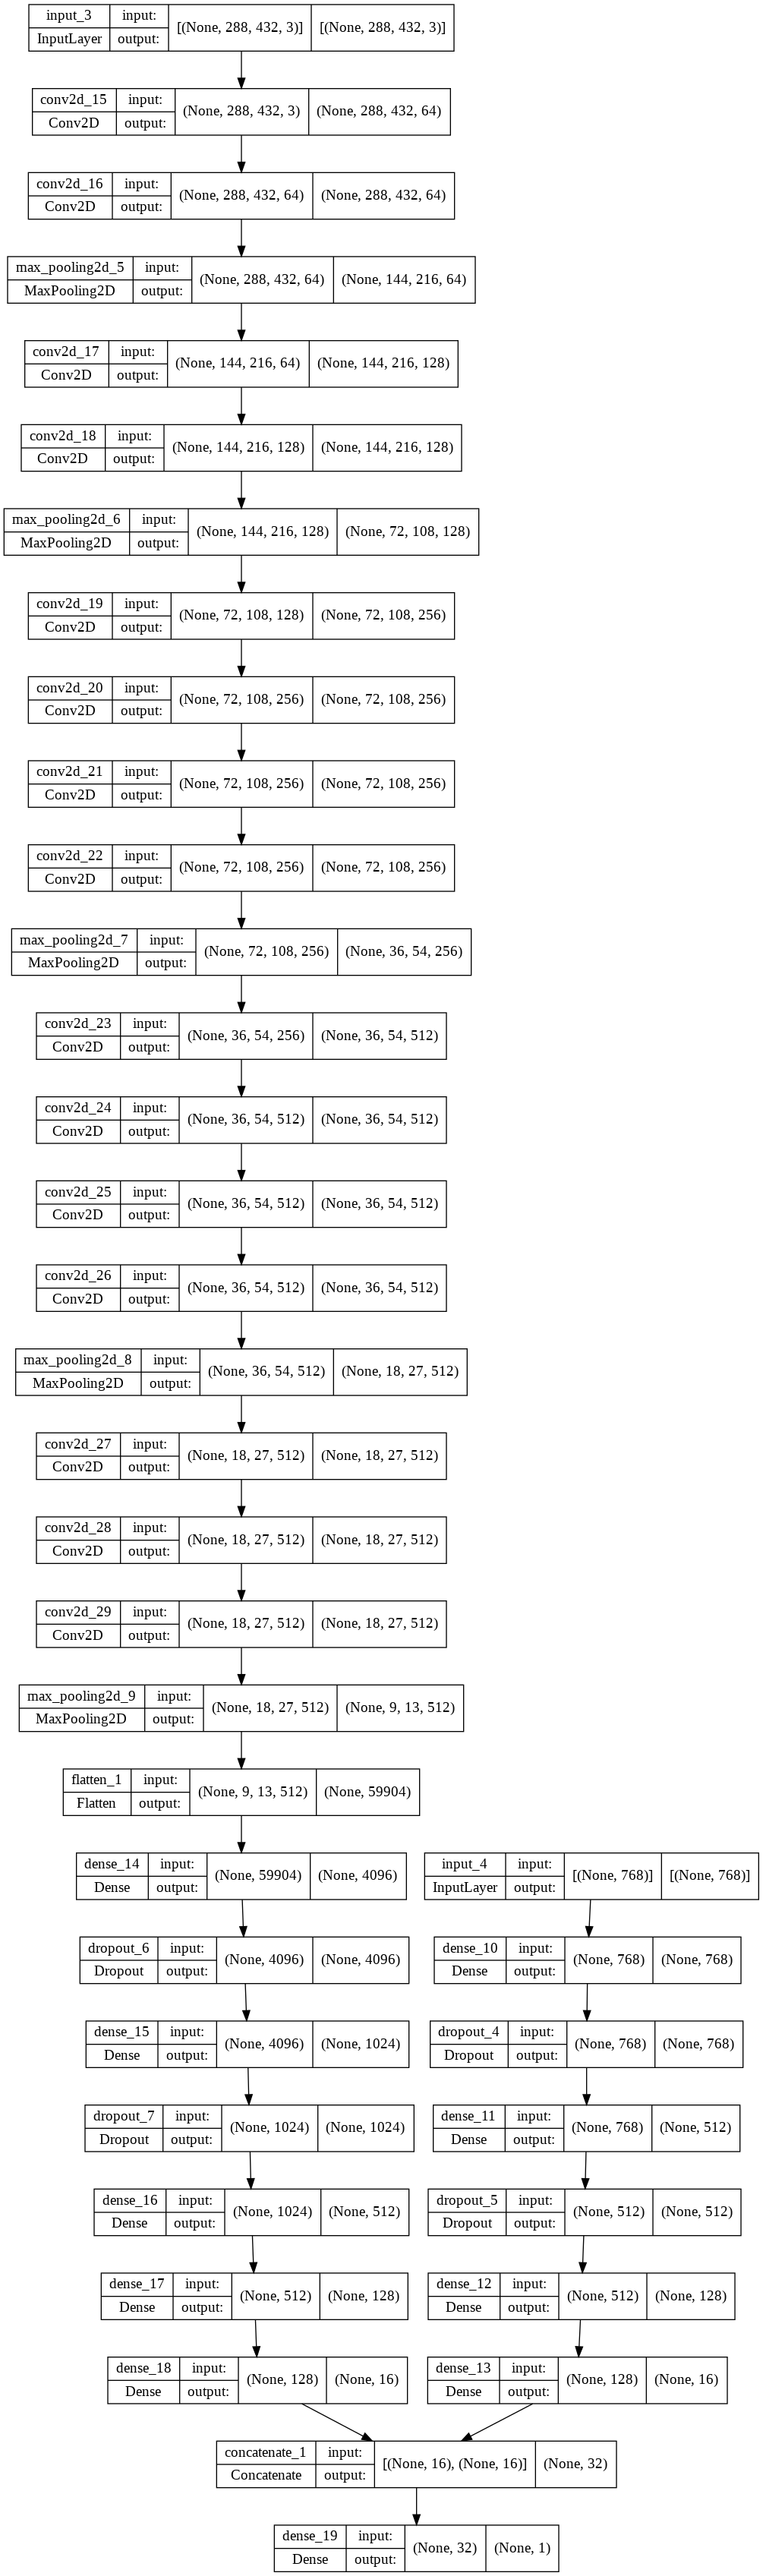

In [ ]:
#scrath implementation of VGG model


# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (5,5), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in



# define model input
input_layer_1 = Input(shape=(288, 432, 3))

input_layer_2 = Input(shape=(768))
# add vgg module
layer = vgg_block(input_layer_1, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 4)
# add vgg module

layer = vgg_block(layer, 512, 4)

# add vgg module

layer = vgg_block(layer, 512, 3)

#text layers 
text_dense_layer_1 = layers.Dense(768, activation='relu')(input_layer_2)
text_dp1 = layers.Dropout(0.5)(text_dense_layer_1)
text_dense_layer_2 = layers.Dense(512, activation='relu')(text_dp1)
text_dp2 = layers.Dropout(0.5)(text_dense_layer_2)
text_dense_layer_3 = layers.Dense(128, activation='relu')(text_dp2)
text_dense_layer_4 = layers.Dense(16, activation='relu')(text_dense_layer_3)

#image fully connected layers
flatten_layer = layers.Flatten()(layer)
dense_layer_1 = layers.Dense(4096, activation='relu')(flatten_layer)
dp1 = layers.Dropout(0.5)(dense_layer_1)
dense_layer_2 = layers.Dense(1024, activation='relu')(dp1)
dp2 = layers.Dropout(0.4)(dense_layer_2)
dense_layer_3 = layers.Dense(512, activation='relu')(dp2)
dense_layer_4 = layers.Dense(128, activation='relu')(dense_layer_3)
dense_layer_5 = layers.Dense(16, activation='relu')(dense_layer_4)

dense_layer = layers.concatenate([text_dense_layer_4,dense_layer_5],axis=1)

prediction_layer = layers.Dense(1)(dense_layer)

# create model
model = Model(inputs=[input_layer_1,input_layer_2], outputs=prediction_layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='Vgg16_with_text__vgg_blocks.png')

In [ ]:
model.compile(optimizer='RMSprop',loss='mse',
    metrics=['mse','mae'],)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit([train_images,train_bert],np.array(train_phq_lables), epochs=30, validation_split=0.2, batch_size=2)


Epoch 1/30
101/101 [==============================] - 64s 576ms/step - loss: 103232293510865485824.0000 - mse: 103232293510865485824.0000 - mae: 1012767424.0000 - val_loss: 0.1091 - val_mse: 0.1091 - val_mae: 0.2968
Epoch 2/30
101/101 [==============================] - 57s 565ms/step - loss: 0.4141 - mse: 0.4141 - mae: 0.4273 - val_loss: 0.1061 - val_mse: 0.1061 - val_mae: 0.2920
Epoch 3/30
101/101 [==============================] - 57s 564ms/step - loss: 0.1308 - mse: 0.1308 - mae: 0.3036 - val_loss: 0.1064 - val_mse: 0.1064 - val_mae: 0.2915
Epoch 4/30
101/101 [==============================] - 56s 559ms/step - loss: 0.1068 - mse: 0.1068 - mae: 0.2803 - val_loss: 0.1651 - val_mse: 0.1651 - val_mae: 0.3422
Epoch 5/30
101/101 [==============================] - 56s 553ms/step - loss: 0.1157 - mse: 0.1157 - mae: 0.2927 - val_loss: 0.1290 - val_mse: 0.1290 - val_mae: 0.3049
Epoch 6/30
101/101 [==============================] - 56s 553ms/step - loss: 0.1106 - mse: 0.1106 - mae: 0.2769 - va

In [ ]:
yhat = model.predict([test_image_array,test_bert])


In [ ]:
yhat

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(yhat, test_phq_lables)
mse = mean_squared_error(yhat,test_phq_lables,squared=True)
print("Mean absolute error on test data: ", mae*23)
print("Root Meansquare error on test data: ", mse*23*23)

Mean absolute error on test data:  6.540864680494581
Root Meansquare error on test data:  57.65482185729757


### Experimenting with VGG16 + text for classification

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 432, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 288, 432, 64  4864        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 288, 432, 64  102464      ['conv2d[0][0]']                 
                                )                                                             

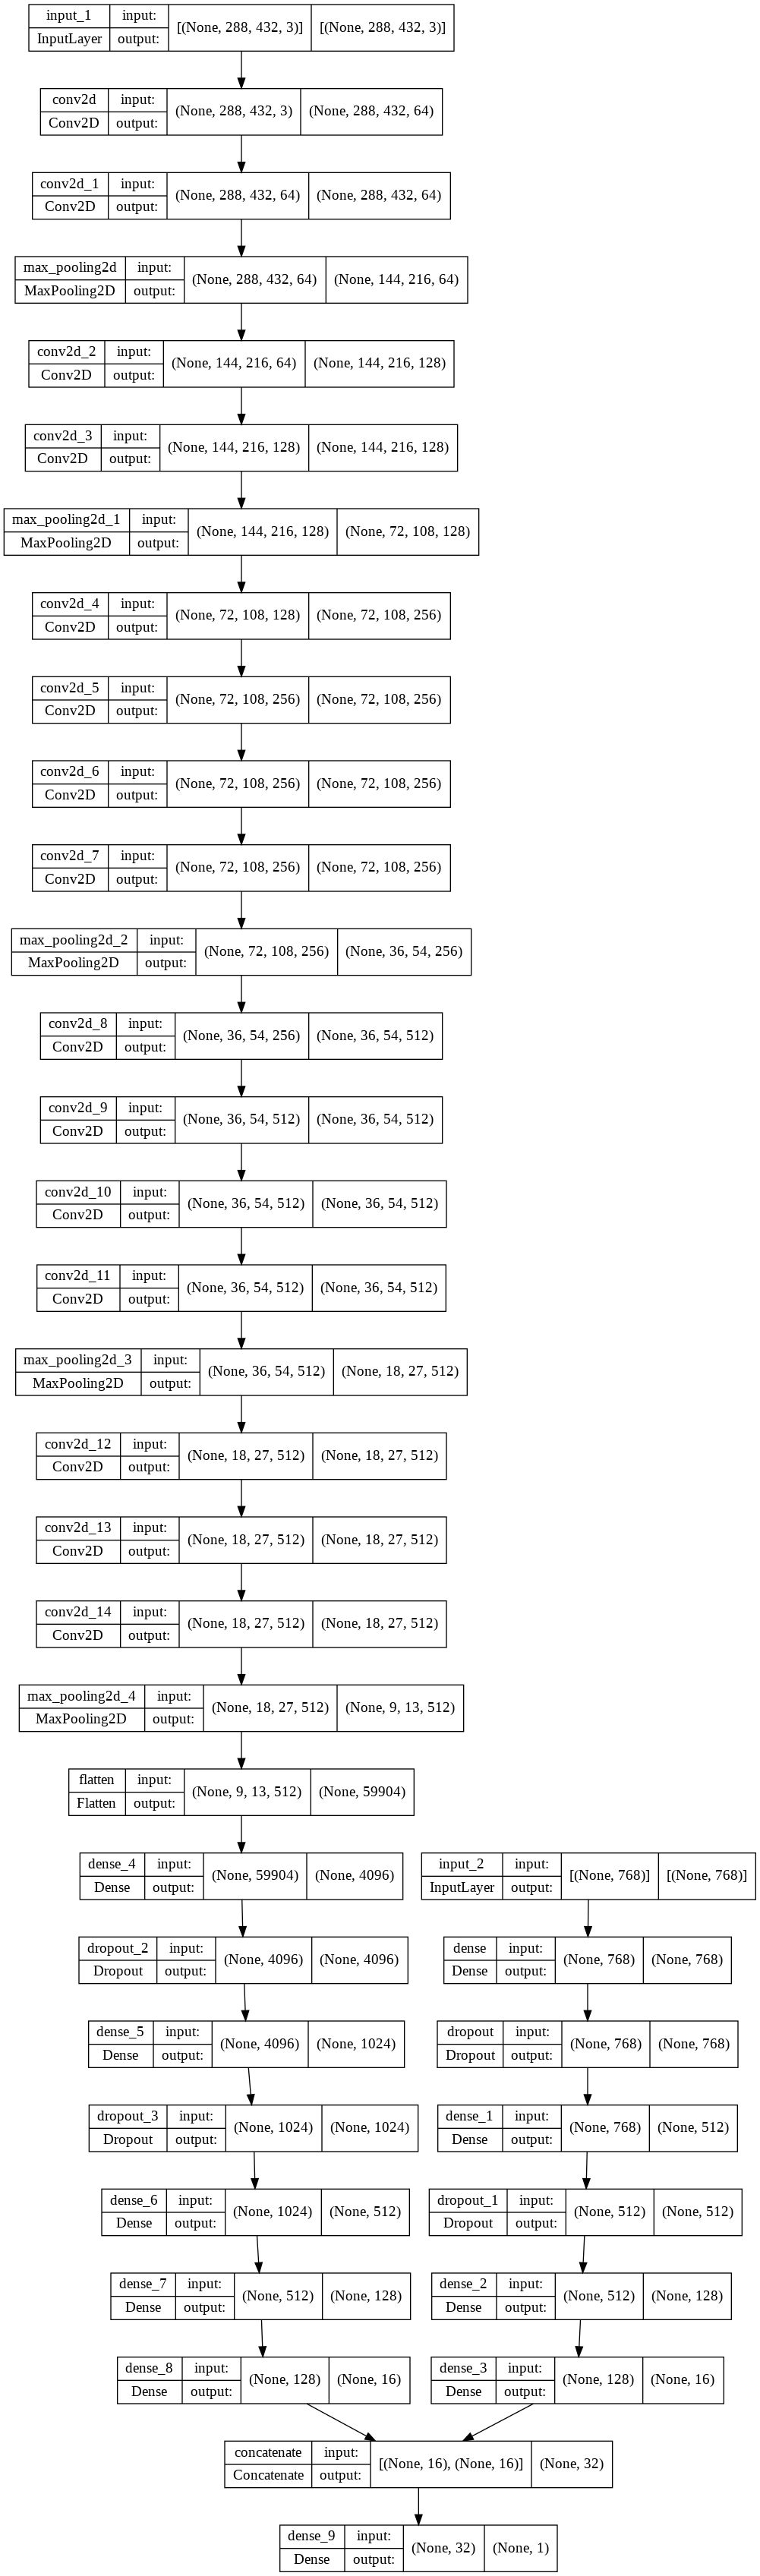

In [18]:
#scrath implementation of VGG model


# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (5,5), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in



# define model input
input_layer_1 = Input(shape=(288, 432, 3))

input_layer_2 = Input(shape=(768))
# add vgg module
layer = vgg_block(input_layer_1, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 4)
# add vgg module

layer = vgg_block(layer, 512, 4)

# add vgg module

layer = vgg_block(layer, 512, 3)

#text layers 
text_dense_layer_1 = layers.Dense(768, activation='relu')(input_layer_2)
text_dp1 = layers.Dropout(0.5)(text_dense_layer_1)
text_dense_layer_2 = layers.Dense(512, activation='relu')(text_dp1)
text_dp2 = layers.Dropout(0.5)(text_dense_layer_2)
text_dense_layer_3 = layers.Dense(128, activation='relu')(text_dp2)
text_dense_layer_4 = layers.Dense(16, activation='relu')(text_dense_layer_3)

#image fully connected layers
flatten_layer = layers.Flatten()(layer)
dense_layer_1 = layers.Dense(4096, activation='relu')(flatten_layer)
dp1 = layers.Dropout(0.5)(dense_layer_1)
dense_layer_2 = layers.Dense(1024, activation='relu')(dp1)
dp2 = layers.Dropout(0.4)(dense_layer_2)
dense_layer_3 = layers.Dense(512, activation='relu')(dp2)
dense_layer_4 = layers.Dense(128, activation='relu')(dense_layer_3)
dense_layer_5 = layers.Dense(16, activation='relu')(dense_layer_4)

dense_layer = layers.concatenate([text_dense_layer_4,dense_layer_5],axis=1)

prediction_layer = layers.Dense(1)(dense_layer)

# create model
model = Model(inputs=[input_layer_1,input_layer_2], outputs=prediction_layer)
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='Vgg16_with_text_classification_vgg_blocks.png')

In [20]:
model.compile(optimizer='RMSprop',loss='mse',
    metrics=['accuracy'],)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit([train_images,train_bert],np.array(train_lables), epochs=50, validation_split=0.2, batch_size=2)


Epoch 1/50
101/101 [==============================] - 46s 336ms/step - loss: 181425294373178834944.0000 - accuracy: 0.5124 - val_loss: 1.1072 - val_accuracy: 0.4706
Epoch 2/50
101/101 [==============================] - 33s 324ms/step - loss: 10.0482 - accuracy: 0.4826 - val_loss: 0.3750 - val_accuracy: 0.4706
Epoch 3/50
101/101 [==============================] - 33s 325ms/step - loss: 27364.6523 - accuracy: 0.5224 - val_loss: 0.7170 - val_accuracy: 0.4706
Epoch 4/50
101/101 [==============================] - 33s 324ms/step - loss: 80.1195 - accuracy: 0.5075 - val_loss: 0.2585 - val_accuracy: 0.5294
Epoch 5/50
101/101 [==============================] - 33s 324ms/step - loss: 0.2900 - accuracy: 0.5771 - val_loss: 0.2783 - val_accuracy: 0.5294
Epoch 6/50
101/101 [==============================] - 33s 324ms/step - loss: 0.2965 - accuracy: 0.4129 - val_loss: 0.3751 - val_accuracy: 0.4706
Epoch 7/50
101/101 [==============================] - 33s 324ms/step - loss: 0.2834 - accuracy: 0.5224 -

In [26]:
yhat = model.predict([test_image_array,test_bert])


In [27]:
yhat = [ 0 if i >0.5 else 1 for i in yhat]

In [28]:
test_lables

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [29]:
from sklearn.metrics import recall_score, accuracy_score
print("Accuracy Score : ", accuracy_score(yhat,test_lables))
print("Recall Score : ", recall_score(yhat, test_lables))

Accuracy Score :  0.6964285714285714
Recall Score :  0.5


### Experimenting Siamese network 

In [ ]:
train_image_array = np.load("train_image_3_channels.npy")
train_bert = np.load("train_text.npy")
test_image_array = np.load("test_image_3_channels.npy")
test_bert = np.load("test_text.npy")


#### Referred from:- https://pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/


In [ ]:
def make_pairs(x, y):
    num_classes = max(y) + 1
    print(num_classes)
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    print(digit_indices)
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        #print(idx1)
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        for i in range(5):
          idx2 = random.choice(digit_indices[label1])
          x2 = x[idx2]

          pairs += [[x1, x2]]
          labels += [1]

          # add a non-matching example
          label2 = random.randint(0, num_classes - 1)
          while label2 == label1:
              label2 = random.randint(0, num_classes - 1)

          idx2 = random.choice(digit_indices[label2])
          x2 = x[idx2]

          pairs += [[x1, x2]]
          labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


In [ ]:
digit_indices = [np.where(train_lable == i)[0] for i in range(2)]


In [ ]:
digit_indices

[array([  0,   1,   2,   3,   4,   7,   9,  10,  11,  12,  13,  14,  16,
         17,  18,  19,  20,  21,  22,  23,  26,  27,  31,  32,  36,  38,
         42,  43,  44,  46,  47,  49,  50,  51,  53,  54,  55,  57,  60,
         61,  62,  63,  65,  66,  67,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  80,  81,  82,  84,  85,  87,  88,  89,  90,  91,
         93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107,
        108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        150, 151, 152, 157, 158, 159, 160, 161, 162]),
 array([  5,   6,   8,  15,  24,  25,  28,  29,  30,  33,  34,  35,  37,
         39,  40,  41,  45,  48,  52,  56,  58,  59,  64,  68,  79,  83,
         86,  92,  95, 105, 114, 119, 149, 153, 154, 155, 156])]

In [ ]:
pairs_train, labels_train = make_pairs(train_image_array, train_lable)


2
[array([  0,   1,   2,   3,   4,   7,   9,  10,  11,  12,  13,  14,  16,
        17,  18,  19,  20,  21,  22,  23,  26,  27,  31,  32,  36,  38,
        42,  43,  44,  46,  47,  49,  50,  51,  53,  54,  55,  57,  60,
        61,  62,  63,  65,  66,  67,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  80,  81,  82,  84,  85,  87,  88,  89,  90,  91,
        93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107,
       108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       150, 151, 152, 157, 158, 159, 160, 161, 162]), array([  5,   6,   8,  15,  24,  25,  28,  29,  30,  33,  34,  35,  37,
        39,  40,  41,  45,  48,  52,  56,  58,  59,  64,  68,  79,  83,
        86,  92,  95, 105, 114, 119, 149, 153, 154, 155, 156])]


In [ ]:
train_image1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
train_image2 = pairs_train[:, 1]

In [ ]:
train_image1.shape

(1630, 288, 432, 3)

In [ ]:
del pairs_train

#### Referred from :- https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras import layers, models
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils.vis_utils import plot_model
import os, sys
import tensorflow as tf
import numpy as np

def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in
def train_siamese(image1,image2,text1,text2,label):
  visible = Input(shape=(288, 432, 3))
  # add vgg module
  layer = vgg_block(visible, 64, 2)
  # add vgg module
  layer = vgg_block(layer, 128, 2)
  # add vgg module
  layer = vgg_block(layer, 256, 4)
  # add vgg module
  layer = vgg_block(layer, 512, 4)
  # add vgg module
  layer = vgg_block(layer, 512, 3)

  flatten_layer = layers.Flatten()(layer)
  dense_layer_1 = layers.Dense(4096, activation='relu')(flatten_layer)
  dp1 = layers.Dropout(0.4)(dense_layer_1)
  dense_layer_2 = layers.Dense(1024, activation='relu')(dp1)
  dp2 = layers.Dropout(0.4)(dense_layer_2)
  dense_layer_3 = layers.Dense(512, activation='relu')(dp2)
  dense_layer_4 = layers.Dense(128, activation='relu')(dense_layer_3)
  prediction_layer = layers.Dense(16)(dense_layer_4)
  norm_embeddings = tf.nn.l2_normalize(prediction_layer, axis=-1)

  model = Model(inputs=visible, outputs=norm_embeddings)

  # Create siamese model
  input1 = Input((288, 432, 3))
  input2 = Input((288, 432, 3))

  # Create left and right twin models
  left_model = model(input1)
  right_model = model(input2)


  # Dot product layer
  dot_product =layers.dot([left_model, right_model], axes=1, normalize=False)

  siamese_model = Model(inputs=[input1, input2], outputs=dot_product)
  print(siamese_model.summary())

  siamese_model.compile(optimizer='adam', loss= 'mse',metrics=['accuracy'],)
 # Fit model
  siamese_model.fit([image1, image2], np.array(label), epochs=30, batch_size=5, shuffle=True, verbose=True)

  model.save(os.getcwd()+"/color_encoder.h5")
  #siamese_model.save(os.getcwd()+"/color_siamese_model.h5")

  # Plot flowchart fo model
  plot_model(siamese_model,'siamese_model.png', show_shapes=1, show_layer_names=1)


In [ ]:
train_siamese(train_image1,train_image2,"k","k",labels_train)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 288, 432, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 288, 432, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 16)           267823312   ['input_2[0][0]',                
                                                                  'input_3[0][0]']          